In [2]:
import pandas as pd
import nltk.data
import numpy as np
import matplotlib.pyplot as plt # plot figures
from nltk.corpus import PlaintextCorpusReader
import os, time, random, re, codecs, spacy, math, torch, spacy, transformers, nltk
from os.path import join
import seaborn as sns # plot figures
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from ipywidgets import IntProgress
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import tensorflow as tf
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import plot_roc_curve
from bert_sklearn import BertClassifier
from bert_sklearn import BertRegressor
from bert_sklearn import load_model
from sklearn.model_selection import GridSearchCV
from transformers import AdamW
import torch.optim as optim
import codecs, json, copy
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from transformers.models.bert.modeling_bert import BertModel,BertForMaskedLM, BertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore') 
import copy
import glob

In [3]:
# Seeding:
def seed_all(seed):  
    ''' A function to seed everything for getting stable results and reproducibility'''
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed = 2021    
seed_all(seed)
# Testing size:
sizeoftest = 0.2

In [4]:
path = '....csv'
df = pd.read_csv(path)
df = df.drop(df.columns[0], axis=1)
# df

In [5]:
path2 = '....csv'
df2 = pd.read_csv(path2)
df2 = df2.drop(df2.columns[0], axis=1)
# df2

In [10]:
df2.shape

(13, 2)

In [11]:
df.shape

(447, 5)

In [12]:
print(df.columns.tolist()) # column names

['end', 'file_key', 'label', 'start', 'str']


In [13]:
df.isnull().any()

end         False
file_key    False
label       False
start       False
str         False
dtype: bool

In [14]:
df.dtypes

end          int64
file_key     int64
label        int64
start        int64
str         object
dtype: object

In [15]:
df['label'].value_counts()

1    356
0     91
Name: label, dtype: int64

In [16]:
df.isnull().any()

end         False
file_key    False
label       False
start       False
str         False
dtype: bool

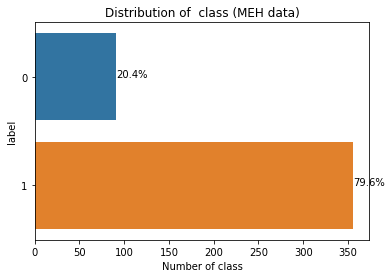

In [17]:
ax = sns.countplot(y="label", data=df)
plt.title('Distribution of  class (MEH data)')
plt.xlabel('Number of class')
total = len(df['label'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.savefig('class_label_meh')
plt.show()

# Term-doc matrix

In [90]:
nlp = spacy.load('en_core_web_sm')
# a dictionary of dictionary to hold document-term freqencies
term_doc = {}
indices = range(len(df));
# a list to hold all distinct terms
terms = []
for idx, text in zip(indices, df['str']):
    doc = nlp(text)
    term_doc[idx] = {}
    for t in doc:
        # ignore stop words, punctuations and tokens not consisting of alphabetic characters 
        if not (t.is_stop or t.is_punct) and t.is_alpha:
            # get the lemma form
            tl = t.lemma_.lower()
            if tl not in terms:
                terms.append(tl)
            term_doc[idx][tl] =  1 if tl not in term_doc[idx] else 1 + term_doc[idx][tl]
print('vocabulary size', len(terms))
# create a dataframe for storing the term-document matrix
df_termdoc = pd.DataFrame()
for d in term_doc:
    col = []
    for t in terms:
        col.append(term_doc[d][t] if t in term_doc[d] else 0)
    df_termdoc[d] = col
df_termdoc.index = terms
df_termdoc.describe()

vocabulary size 105


,0,1,2,3,4,5,6,7,8,9,...,437,438,439,440,441,442,443,444,445,446
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,...,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,0.019048,0.009524,0.019048,0.009524,0.019048,0.019048,0.009524,0.019048,0.019048,0.019048,...,0.009524,0.019048,0.019048,0.019048,0.019048,0.019048,0.019048,0.019048,0.019048,0.019048
std,0.137348,0.097590,0.137348,0.097590,0.137348,0.137348,0.097590,0.137348,0.137348,0.137348,...,0.097590,0.137348,0.137348,0.137348,0.137348,0.137348,0.137348,0.137348,0.137348,0.137348
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
df_termdoc.head()

,0,1,2,3,4,5,6,7,8,9,...,437,438,439,440,441,442,443,444,445,446
usher,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
syndrome,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
good,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
macular,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,0,1
oedema,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
terms = pd.DataFrame([sum(df_termdoc.loc[r]) for r in df_termdoc.index])
terms.index = df_termdoc.index
terms.columns = ['freq']
terms.sort_values(by='freq', ascending=False, inplace=True)
terms.head()

,freq
macular,79
dystrophy,64
good,47
stargardt,39
atrophy,32


In [93]:
df_termdoc.shape

(105, 447)

# Term-term matrix

In [94]:
# a function to process current token: count frequncies of neighbouring tokens
def process_a_token(prev_win, next_win, win_size, current_token, t2c):
    for c in prev_win + next_win:
        if current_token not in t2c:
            t2c[current_token] = {}
        t2c[current_token][c] = 1 if c not in t2c[current_token] else t2c[current_token][c] + 1

        
def process_wins_pipeline(current_token, prev_win, next_win, win_size, t2c, new_lemma_term):
    #deal with a pipeline: [prev_win, current_token, next_win]
    # a) move a token forward from right to left and push a new token in if available
    # b) deal with the new current_token
#     print(prev_win, current_token, next_win)
    # process current_token
    process_a_token(prev_win, next_win, win_size, current_token, t2c)
    if len(prev_win) >= win_size:
        #pop one out if prev_win has win_size words or more
        prev_win.pop(0)
    # push previous processed token to prev_win stach
    prev_win.append(current_token)
    # get the first token from the next_win as the current_token
    if len(next_win) > 0:
        current_token = next_win.pop(0)
    else:
        current_token = None
    # push the newly read token the next_win stack
    if new_lemma_term is not None:
        next_win.append(new_lemma_term)
    
    return current_token


# a dictionary of dictionary to store the term to context word frequencies
t2c = {}
# define the neighbouring word window size
win_size = 4

for text in df['str']:
    doc = nlp(text)
    # two lists used as stacks for two prev/next words' windows
    prev_win = [] 
    next_win = []
    current_token = None
    init_wins_read = False

    # read windows
    for t in doc:
        # ignore stop words, punctuations and tokens not consisting of alphabetic characters 
        if not (t.is_stop or t.is_punct) and t.is_alpha:
            if not init_wins_read:
                # keep reading tokens until the next_win's length reaches win_size
                if current_token is None:
                    # if first token hasn't been read, set the first token as current_token to be processed
                    current_token = t.lemma_.lower()
                else:
                    # fill next_win
                    next_win.append(t.lemma_.lower())
                if len(next_win) == win_size:
                    init_wins_read = True
            else:
                # normal status: win_size words loaded in the next_win stack
                current_token = process_wins_pipeline(current_token, prev_win, next_win, win_size, t2c, t.lemma_.lower())
                
    while current_token is not None:
        # deal with leftovers in the next_win stack
        if not init_wins_read:
            # next_win is not filled fully before all tokens read
            process_a_token(prev_win, next_win, win_size, current_token, t2c)
            init_wins_read = True
        else:
            current_token = process_wins_pipeline(current_token, prev_win, next_win, win_size, t2c, None)

print('vocabulary size:', len(t2c))

vocabulary size: 83


In [95]:
# create a dataframe to store the term-term matrix
terms = []
contexts = []
for t in t2c:
    if t not in terms:
        terms.append(t)
    for c in t2c[t]:
        if c not in contexts:
            contexts.append(c)
data = {}
for t in terms:
    data[t] = [(t2c[t][c] if c in t2c[t] else 0) for c in contexts]
df_termterm = pd.DataFrame.from_dict(data, orient='index')
df_termterm.columns = contexts
df_termterm.describe()

,syndrome,usher,oedema,edema,atrophy,dystrophy,disease,age,relate,degeneration,...,blind,cone,deposit,drusenlike,amaurosis,congenital,scar,eyesight,eog,abnormal
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,...,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.240964,0.120482,0.168675,0.024096,0.807229,1.542169,0.722892,0.072289,0.096386,0.313253,...,0.012048,0.012048,0.024096,0.012048,0.120482,0.060241,0.024096,0.024096,0.024096,0.012048
std,2.195285,1.097643,1.536700,0.219529,4.088824,12.588517,5.931136,0.375569,0.532240,1.834146,...,0.109764,0.109764,0.219529,0.109764,1.097643,0.548821,0.219529,0.219529,0.219529,0.109764
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,20.000000,10.000000,14.000000,2.000000,28.000000,114.000000,54.000000,2.000000,4.000000,16.000000,...,1.000000,1.000000,2.000000,1.000000,10.000000,5.000000,2.000000,2.000000,2.000000,1.000000


In [96]:
df_termterm.head()

,syndrome,usher,oedema,edema,atrophy,dystrophy,disease,age,relate,degeneration,...,blind,cone,deposit,drusenlike,amaurosis,congenital,scar,eyesight,eog,abnormal
usher,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
syndrome,0,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
macular,0,0,14,2,22,114,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
oedema,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
retinitis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
df_termterm.shape

(83, 83)

# TF-IDF matrix

In [98]:
# make a deep copy of term-document matrix
df_tfidf = df_termdoc.copy(deep=True)
# create a IDF dataframe
# 1.1 init it with count document frequencies
df_idf = pd.DataFrame([sum([(1 if df_tfidf.loc[t, c] > 0 else 0) for c in df_tfidf.columns]) for t in df_tfidf.index])
df_idf.index = df_termdoc.index
# 1.2 calculate log10(N/df)
df_idf = df_idf.applymap(lambda x: math.log(df_tfidf.shape[1] / x, 10))

# 2.1 calculate log10(tf + 1)
df_tfidf = df_tfidf.applymap(lambda x: math.log(x + 1, 10))
# 2.2 calculate tf-idf: log10(tf + 1) * log10(N/df)
df_tfidf = df_tfidf.apply(lambda x: x * df_idf.loc[x.name, 0], axis=1)
df_tfidf.head(5)

,0,1,2,3,4,5,6,7,8,9,...,437,438,439,440,441,442,443,444,445,446
usher,0.496792,0.00000,0.000000,0.00000,0.496792,0.0,0.00000,0.496792,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
syndrome,0.496792,0.00000,0.000000,0.00000,0.496792,0.0,0.00000,0.496792,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
good,0.000000,0.29447,0.000000,0.29447,0.000000,0.0,0.29447,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
macular,0.000000,0.00000,0.226579,0.00000,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.226579,0.0,0.0,0.226579,0.226579,0.0,0.0,0.0,0.226579
oedema,0.000000,0.00000,0.543422,0.00000,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [99]:
df_tfidf.shape

(105, 447)

# PPMI matrix

In [100]:
ppmi_df = df_termterm.copy(deep=True)

# save the term frequencies first
term_probs = pd.DataFrame([sum(ppmi_df.loc[r]) for r in ppmi_df.index])
term_probs.index = df_termterm.index

# save the context word frequencies first
context_probs = pd.DataFrame([sum(ppmi_df[c]) for c in ppmi_df.columns])
context_probs.index = df_termterm.columns

# calculate the total word frequency
total_freq_sum = term_probs.sum() + context_probs.sum()
total_freq_sum = total_freq_sum.loc[0]
print('total word occurrence times:', total_freq_sum)

total word occurrence times: 1956


In [101]:
# convert each cell from frequency to probability
ppmi_df = ppmi_df.apply(lambda x: x/total_freq_sum)
ppmi_df.head()
# ppmi_df.isnull().any()
# ppmi_df.isna().sum() #count how many missing data each feature has

,syndrome,usher,oedema,edema,atrophy,dystrophy,disease,age,relate,degeneration,...,blind,cone,deposit,drusenlike,amaurosis,congenital,scar,eyesight,eog,abnormal
usher,0.010225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
syndrome,0.000000,0.005112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
macular,0.000000,0.000000,0.007157,0.001022,0.011247,0.058282,0.001022,0.001022,0.001022,0.001022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oedema,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
retinitis,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
# get the probabilities of both context and term series
context_probs = context_probs.apply(lambda x: x/total_freq_sum)
term_probs = term_probs.apply(lambda x: x/total_freq_sum)
# calculate the PPMI
# 1. divide each cell by relevant term probability
ppmi_df = ppmi_df.apply(lambda r: r / term_probs.loc[r.name, 0], axis=1)
# 2. divide each cell by relevant context probability
ppmi_df = ppmi_df.apply(lambda c: c / context_probs.loc[c.name, 0])
# 3. for those non-zero cells do the log calculation and change negatives to zero
ppmi_df[ppmi_df != 0] = ppmi_df[ppmi_df != 0].applymap(lambda c: max(0, math.log(c, 2)))
ppmi_df.describe()

,syndrome,usher,oedema,edema,atrophy,dystrophy,disease,age,relate,degeneration,...,blind,cone,deposit,drusenlike,amaurosis,congenital,scar,eyesight,eog,abnormal
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,...,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.079660,0.091708,0.043515,0.043515,0.151306,0.063600,0.100797,0.171475,0.156473,0.232183,...,0.131731,0.112635,0.119683,0.131731,0.091708,0.103756,0.091708,0.103756,0.119683,0.131731
std,0.725735,0.835499,0.396442,0.396442,0.715982,0.426186,0.651496,0.969219,0.898106,1.043910,...,1.200128,1.026156,1.090364,1.200128,0.835499,0.945264,0.835499,0.945264,1.090364,1.200128
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.611763,7.611763,3.611763,3.611763,4.768066,3.444653,5.026800,6.763766,6.348728,5.648288,...,10.933691,9.348728,9.933691,10.933691,7.611763,8.611763,7.611763,8.611763,9.933691,10.933691


In [103]:
ppmi_df.head()

,syndrome,usher,oedema,edema,atrophy,dystrophy,disease,age,relate,degeneration,...,blind,cone,deposit,drusenlike,amaurosis,congenital,scar,eyesight,eog,abnormal
usher,6.611763,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
syndrome,0.000000,7.611763,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
macular,0.000000,0.000000,3.611763,3.611763,2.005105,3.444653,0.0,2.0268,1.611763,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oedema,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
retinitis,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
ppmi_df.shape

(83, 83)

# Document classification

In [105]:
def rf_classification(X, y, test_size=sizeoftest, random_state=seed):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    rfc = RandomForestClassifier(random_state=random_state)
    rfc.fit(X_train, y_train)

    # predictions
    rfc_predict = rfc.predict(X_test)
    return classification_report(y_test, rfc_predict)


def svm_classification(X, y, test_size=sizeoftest, random_state=seed):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    svc = SVC(random_state=random_state)
    svc.fit(X_train, y_train)

    # predictions
    svc_predict = svc.predict(X_test)
    return classification_report(y_test, svc_predict)

In [108]:
# classificaiton results    
labels = [0, 1]
y = [labels.index(df.loc[d, 'label']) for d in df.index]
# del y[-1]

print('========== Term frequency represetation result (random forest) ==========')
print(rf_classification(df_termdoc.transpose(), y))
print('========== Term frequency represetation result (svm) ==========')
print(svm_classification(df_termdoc.transpose(), y))
print('==========     TF-IDF represetation result (random forest)    ==========')
print(rf_classification(df_tfidf.transpose(), y))
print('==========     TF-IDF represetation result (svm)    ==========')
print(svm_classification(df_tfidf.transpose(), y))
# print('==========     PPMI represetation result (random forest)    ==========')
# ppmi_df = ppmi_df.reindex(df_termdoc.index)
# print(rf_classification(df_termdoc.transpose().dot(ppmi_df), y))
# print('==========     PPMI represetation result (svm)    ==========')
# ppmi_df = ppmi_df.reindex(df_termdoc.index)
# print(svm_classification(df_termdoc.transpose().dot(ppmi_df), y))

========== Term frequency represetation result (random forest) ==========
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.94      0.97      0.95        75

    accuracy                           0.92        90
   macro avg       0.88      0.82      0.85        90
weighted avg       0.92      0.92      0.92        90

========== Term frequency represetation result (svm) ==========
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.94      0.97      0.95        75

    accuracy                           0.92        90
   macro avg       0.88      0.82      0.85        90
weighted avg       0.92      0.92      0.92        90

==========     TF-IDF represetation result (random forest)    ==========
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.94   